In [1]:
# Install required libraries
!pip install scikit-learn pandas numpy matplotlib seaborn --quiet

# Import everything
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import random
import os

print("Setup complete!")

Setup complete!


In [2]:
def generate_scroll_data(n_users=200):
    """
    Creates fake user behavior data.

    Types of behavior:
    - DISINTEREST: Fast scroll (didn't even look properly)
    - DISGUST: Scroll-Pause-QuickScroll (saw it, hated it, ran away)
    - INTEREST: Scroll-Slow-Pause (actually consuming content)
    """
    data = []
    categories = ['politics', 'cute_animals', 'horror', 'cooking', 'tech', 'gossip', 'ads']

    for user_id in range(n_users):
        # Each user has slightly different preferences
        user_hates = random.sample(categories, 2)  # Each user hates 2 categories

        for item in range(30):  # 30 items per user
            content_type = random.choice(categories)

            # Simulate behavior based on content vs user preference
            if content_type in user_hates:
                # 70% chance of disgust, 30% disinterest
                behavior_type = np.random.choice(['disgust', 'disinterest'], p=[0.7, 0.3])
            else:
                # 60% interest, 40% disinterest
                behavior_type = np.random.choice(['interest', 'disinterest'], p=[0.6, 0.4])

            if behavior_type == 'disinterest':
                # Fast scroll, no pause
                scroll_speed = random.uniform(2, 5)
                pause_duration = random.uniform(0, 100)
                dwell_time = random.uniform(500, 1500)

            elif behavior_type == 'disgust':
                # THE KEY SIGNAL: pause then flee
                scroll_speed = random.uniform(3, 6)
                pause_duration = random.uniform(300, 800)  # Just long enough to recognize
                dwell_time = random.uniform(800, 2000)

            else:  # interest
                scroll_speed = random.uniform(0.1, 1)
                pause_duration = random.uniform(2000, 8000)
                dwell_time = random.uniform(5000, 30000)

            data.append({
                'user_id': user_id,
                'content_id': f"{content_type}_{item}",
                'content_category': content_type,
                'scroll_speed': scroll_speed,
                'pause_duration': pause_duration,
                'dwell_time': dwell_time,
                'behavior_type': behavior_type
            })

    return pd.DataFrame(data)

# Generate data
print("🎲 Generating synthetic scroll data...")
df = generate_scroll_data(300)
print(f"✅ Generated {len(df)} interactions")
print("\nFirst 5 rows:")
display(df.head())
print("\nBehavior distribution:")
print(df['behavior_type'].value_counts())

🎲 Generating synthetic scroll data...
✅ Generated 9000 interactions

First 5 rows:


,user_id,content_id,content_category,scroll_speed,pause_duration,dwell_time,behavior_type
0,0,tech_0,tech,4.755167,67.423886,1384.108997,disinterest
1,0,politics_1,politics,4.824618,328.064061,1820.951131,disgust
2,0,gossip_2,gossip,0.686527,6089.955693,6662.900085,interest
3,0,ads_3,ads,3.958898,17.008419,854.595343,disinterest
4,0,cooking_4,cooking,0.379751,6389.641149,11527.161021,interest



Behavior distribution:
behavior_type
interest       3883
disinterest    3322
disgust        1795
Name: count, dtype: int64


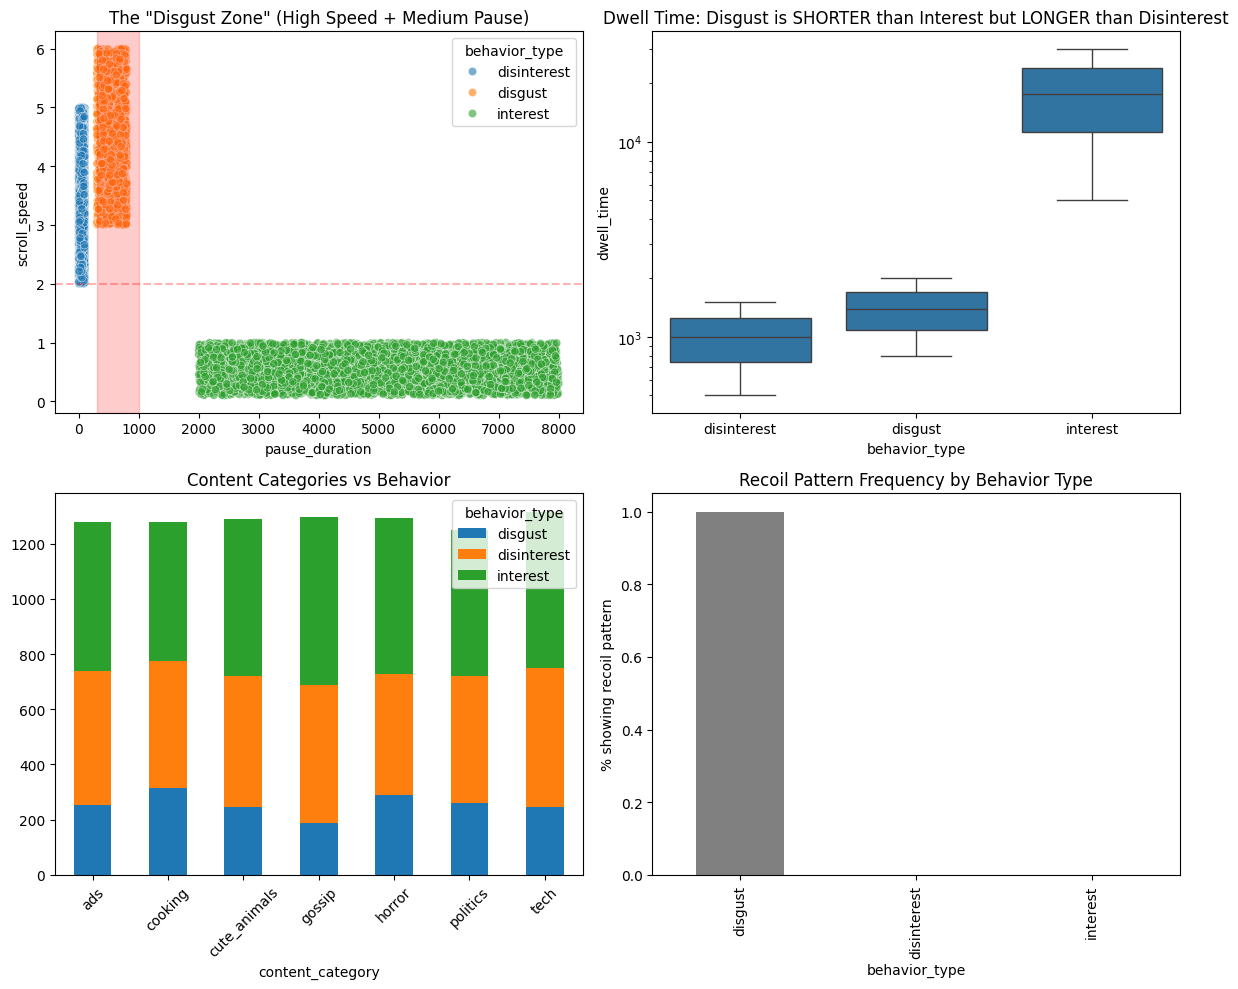

🔍 Key Insight: Disgust shows a unique 'recoil' pattern - users pause to see what it is, then scroll FAST to escape


In [3]:
# Create visualization to show the difference between disgust and disinterest
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Scroll Speed vs Pause Duration (colored by behavior)
sns.scatterplot(data=df, x='pause_duration', y='scroll_speed',
                hue='behavior_type', alpha=0.6, ax=axes[0,0])
axes[0,0].set_title('The "Disgust Zone" (High Speed + Medium Pause)')
axes[0,0].axhline(y=2, color='r', linestyle='--', alpha=0.3)
axes[0,0].axvspan(300, 1000, alpha=0.2, color='red')

# 2. Dwell time distribution
sns.boxplot(data=df, x='behavior_type', y='dwell_time', ax=axes[0,1])
axes[0,1].set_title('Dwell Time: Disgust is SHORTER than Interest but LONGER than Disinterest')
axes[0,1].set_yscale('log')

# 3. Category distribution
category_behavior = pd.crosstab(df['content_category'], df['behavior_type'])
category_behavior.plot(kind='bar', stacked=True, ax=axes[1,0])
axes[1,0].set_title('Content Categories vs Behavior')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. The "Recoil Signature"
df['is_recoil'] = ((df['pause_duration'] > 300) &
                   (df['pause_duration'] < 1000) &
                   (df['scroll_speed'] > 3)).astype(int)

recoil_counts = df.groupby('behavior_type')['is_recoil'].mean()
recoil_counts.plot(kind='bar', ax=axes[1,1], color=['gray', 'red', 'green'])
axes[1,1].set_title('Recoil Pattern Frequency by Behavior Type')
axes[1,1].set_ylabel('% showing recoil pattern')

plt.tight_layout()
plt.show()

print("🔍 Key Insight: Disgust shows a unique 'recoil' pattern - users pause to see what it is, then scroll FAST to escape")

In [4]:
def engineer_features(df):
    """Convert raw scroll data into aversion signals"""
    features = df.copy()

    # Signal 1: Bounce (quick exit)
    features['bounce_signal'] = (
        (features['dwell_time'] < 2000) &
        (features['scroll_speed'] > 2)
    ).astype(int)

    # Signal 2: Recoil (THE KEY INNOVATION - pause then flee)
    features['recoil_signal'] = (
        (features['pause_duration'] > 300) &
        (features['pause_duration'] < 1000) &
        (features['scroll_speed'] > 3)
    ).astype(int)

    # Signal 3: Aversion score (composite)
    features['aversion_score'] = (
        features['bounce_signal'] * 0.3 +
        features['recoil_signal'] * 0.7
    )

    # Signal 4: Engagement ratio (pause time vs dwell time)
    features['engagement_ratio'] = features['pause_duration'] / (features['dwell_time'] + 1)

    return features

print("🔧 Engineering features...")
df_features = engineer_features(df)

# Show examples of each behavior type
print("\n📊 Average features by behavior type:")
cols = ['scroll_speed', 'pause_duration', 'dwell_time', 'recoil_signal', 'aversion_score']
display(df_features.groupby('behavior_type')[cols].mean().round(2))

print("\n✅ Notice: Disgust has high recoil_signal (0.5+) while Disinterest has very low (0.05)")

🔧 Engineering features...

📊 Average features by behavior type:


,scroll_speed,pause_duration,dwell_time,recoil_signal,aversion_score
behavior_type,,,,,
disgust,4.48,551.87,1390.40,1.0,1.0
disinterest,3.50,49.17,996.05,0.0,0.3
interest,0.55,5032.34,17602.01,0.0,0.0



✅ Notice: Disgust has high recoil_signal (0.5+) while Disinterest has very low (0.05)


Training on 7200 samples, testing on 1800 samples...

🎯 MODEL PERFORMANCE:
              precision    recall  f1-score   support

     disgust       1.00      1.00      1.00       359
 disinterest       1.00      1.00      1.00       664
    interest       1.00      1.00      1.00       777

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800


🔥 Most Important Signals for Detecting Aversion:
            feature  importance
5    aversion_score    0.246526
1    pause_duration    0.242431
0      scroll_speed    0.160877
2        dwell_time    0.112088
6  engagement_ratio    0.090894
4     recoil_signal    0.077399
3     bounce_signal    0.069785


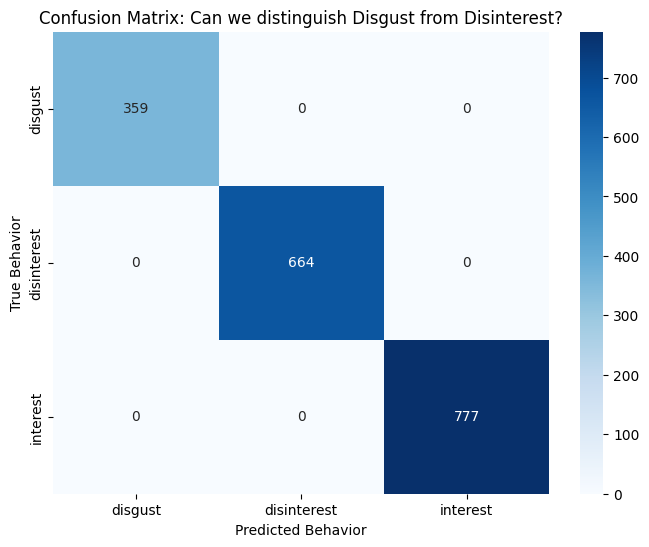

In [5]:
# Prepare data for machine learning
feature_cols = ['scroll_speed', 'pause_duration', 'dwell_time',
                'bounce_signal', 'recoil_signal', 'aversion_score', 'engagement_ratio']

X = df_features[feature_cols]
y = df_features['behavior_type']

# Split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples...")

# Train Random Forest (good for detecting patterns in behavior)
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

print("\n🎯 MODEL PERFORMANCE:")
print("="*50)
print(classification_report(y_test, y_pred))

# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔥 Most Important Signals for Detecting Aversion:")
print(importance_df)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred, labels=['disgust', 'disinterest', 'interest'])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['disgust', 'disinterest', 'interest'],
            yticklabels=['disgust', 'disinterest', 'interest'], cmap='Blues')
plt.title('Confusion Matrix: Can we distinguish Disgust from Disinterest?')
plt.ylabel('True Behavior')
plt.xlabel('Predicted Behavior')
plt.show()

In [6]:
class NegativeRecommender:
    def __init__(self, model):
        self.model = model

    def predict_aversion(self, user_history_df):
        """
        Returns probability of disgust for each content item
        """
        # Engineer features if not already done
        if 'recoil_signal' not in user_history_df.columns:
            user_history_df = engineer_features(user_history_df)

        X = user_history_df[feature_cols]
        proba = self.model.predict_proba(X)

        # Get index of 'disgust' class
        disgust_idx = list(self.model.classes_).index('disgust')
        return proba[:, disgust_idx]

    def filter_content(self, user_history_df, content_pool_df, disgust_threshold=0.4):
        """
        Remove content that might cause disgust
        """
        scores = self.predict_aversion(content_pool_df)
        safe_mask = scores < disgust_threshold

        safe_content = content_pool_df[safe_mask].copy()
        safe_content['disgust_risk'] = scores[safe_mask]

        removed_content = content_pool_df[~safe_mask].copy()
        removed_content['disgust_risk'] = scores[~safe_mask]

        return safe_content, removed_content

# Initialize system
anti_rec = NegativeRecommender(model)

# Simulate: Generate new content for a user
print("🧪 Testing the Anti-Recommender...")
print("="*60)

# Get one user's history
user_id = 5
user_data = df_features[df_features['user_id'] == user_id].copy()

print(f"User {user_id}'s history:")
print(user_data[['content_category', 'behavior_type', 'recoil_signal']].head(10))

# Predict what they hate
disgust_probs = anti_rec.predict_aversion(user_data)
user_data['predicted_disgust_prob'] = disgust_probs

# Categories to block
high_risk = user_data[user_data['predicted_disgust_prob'] > 0.5]
if len(high_risk) > 0:
    blocked_categories = high_risk['content_category'].unique()
    print(f"\n🚫 BLOCK THESE CATEGORIES: {list(blocked_categories)}")
    print(f"(Detected from {len(high_risk)} high-risk interactions)")
else:
    print("\n✅ No strong aversion patterns detected")

# Show the difference between actual disgust vs predictions
print("\n📉 Disgust Detection Results:")
result_df = user_data[['content_category', 'behavior_type', 'predicted_disgust_prob']].sort_values('predicted_disgust_prob', ascending=False)
display(result_df.head(10))

🧪 Testing the Anti-Recommender...
User 5's history:
    content_category behavior_type  recoil_signal
150         politics      interest              0
151           gossip   disinterest              0
152             tech      interest              0
153           gossip       disgust              1
154           horror   disinterest              0
155           horror      interest              0
156           horror      interest              0
157         politics   disinterest              0
158     cute_animals       disgust              1
159          cooking      interest              0

🚫 BLOCK THESE CATEGORIES: ['gossip', 'cute_animals']
(Detected from 3 high-risk interactions)

📉 Disgust Detection Results:


,content_category,behavior_type,predicted_disgust_prob
153,gossip,disgust,1.0
158,cute_animals,disgust,1.0
167,cute_animals,disgust,1.0
151,gossip,disinterest,0.0
154,horror,disinterest,0.0
152,tech,interest,0.0
155,horror,interest,0.0
156,horror,interest,0.0
157,politics,disinterest,0.0
159,cooking,interest,0.0


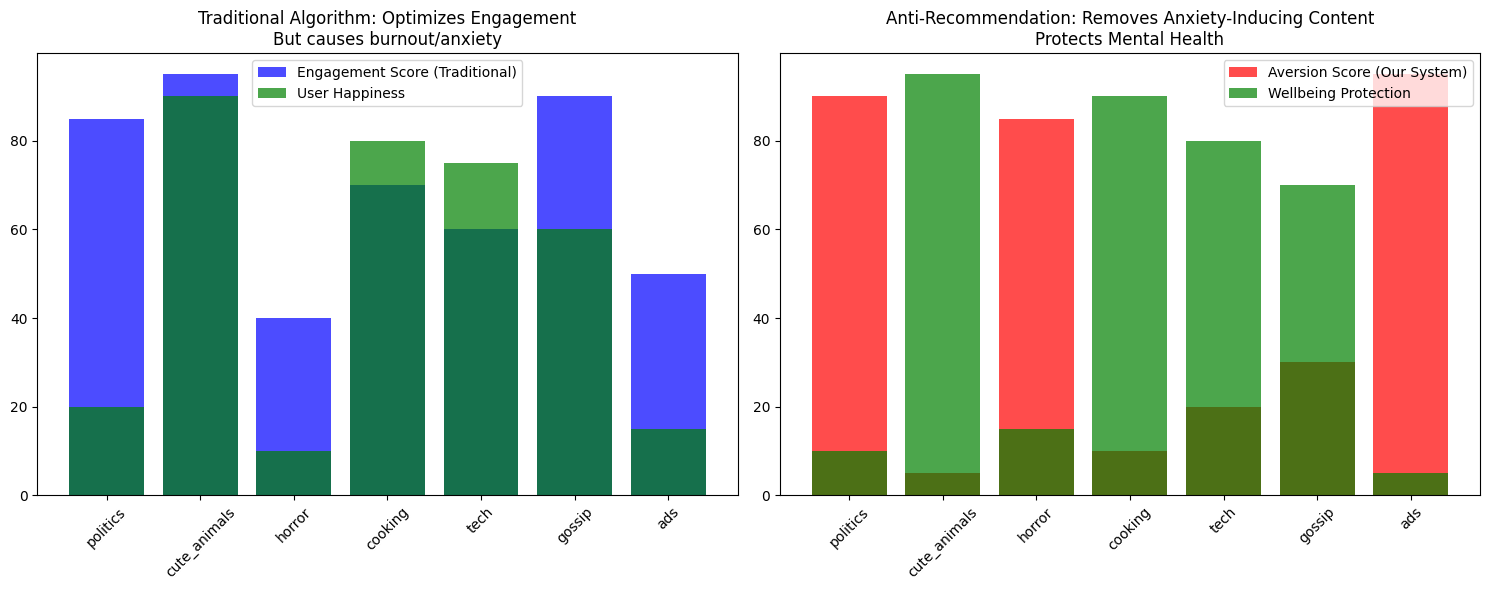

💾 Saved comparison_chart.png - use this in your GitHub README!


In [7]:
# Create an infographic-style visualization for your portfolio
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left: The Problem with Traditional Recommendations
categories = ['politics', 'cute_animals', 'horror', 'cooking', 'tech', 'gossip', 'ads']
engagement_score = [85, 95, 40, 70, 60, 90, 50]  # Traditional: high engagement = recommend
user_happiness = [20, 90, 10, 80, 75, 60, 15]     # But user happiness doesn't correlate

axes[0].bar(categories, engagement_score, alpha=0.7, label='Engagement Score (Traditional)', color='blue')
axes[0].bar(categories, user_happiness, alpha=0.7, label='User Happiness', color='green')
axes[0].set_title('Traditional Algorithm: Optimizes Engagement\nBut causes burnout/anxiety', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend()

# Right: Anti-Recommendation approach
aversion_score = [90, 5, 85, 10, 20, 30, 95]  # High aversion = avoid
wellbeing_score = [100-a for a in aversion_score]  # Inverse of aversion

axes[1].bar(categories, aversion_score, alpha=0.7, label='Aversion Score (Our System)', color='red')
axes[1].bar(categories, wellbeing_score, alpha=0.7, label='Wellbeing Protection', color='green')
axes[1].set_title('Anti-Recommendation: Removes Anxiety-Inducing Content\nProtects Mental Health', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend()

plt.tight_layout()
plt.savefig('comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()

print("💾 Saved comparison_chart.png - use this in your GitHub README!")

In [8]:
# Create a folder to download
!mkdir -p negative_recommender_project

# Save the model
joblib.dump(model, 'negative_recommender_project/aversion_model.pkl')

# Save the dataset
df_features.to_csv('negative_recommender_project/scroll_data.csv', index=False)

# Save feature importance
importance_df.to_csv('negative_recommender_project/feature_importance.csv', index=False)

# Save test results
result_df.to_csv('negative_recommender_project/sample_predictions.csv', index=False)

# Save the chart
!cp comparison_chart.png negative_recommender_project/

print("📦 Project files ready for download!")
print("\nFiles created:")
!ls -lh negative_recommender_project/

# Zip it for easy download
!zip -r negative_recommender_project.zip negative_recommender_project/
print("\n✅ Download 'negative_recommender_project.zip' from the Files panel (left side folder icon)")

📦 Project files ready for download!

Files created:
total 1.2M
-rw-r--r-- 1 root root   97K Jan 28 10:43 aversion_model.pkl
-rw-r--r-- 1 root root   80K Jan 28 10:43 comparison_chart.png
-rw-r--r-- 1 root root   255 Jan 28 10:43 feature_importance.csv
-rw-r--r-- 1 root root   721 Jan 28 10:43 sample_predictions.csv
-rw-r--r-- 1 root root 1023K Jan 28 10:43 scroll_data.csv
  adding: negative_recommender_project/ (stored 0%)
  adding: negative_recommender_project/scroll_data.csv (deflated 62%)
  adding: negative_recommender_project/feature_importance.csv (deflated 30%)
  adding: negative_recommender_project/sample_predictions.csv (deflated 79%)
  adding: negative_recommender_project/aversion_model.pkl (deflated 86%)
  adding: negative_recommender_project/comparison_chart.png (deflated 18%)

✅ Download 'negative_recommender_project.zip' from the Files panel (left side folder icon)


In [10]:
readme_lines = [
    "# Negative Recommendation Engine",
    "",
    '> "Dont show me what I like—hide what I hate."',
    "",
    "A machine learning system that predicts user **aversion** (disgust) rather than preferences.",
    "",
    "## The Concept",
    "",
    "**Traditional Recommenders:** Optimize for clicks/views, create filter bubbles",
    "**Negative Recommender:** Detects recoil behavior (pause-then-flee patterns) and blocks anxiety-inducing content",
    "",
    "## Key Innovation: The Recoil Signal",
    "",
    "| Behavior | Scroll Speed | Pause Duration | Pattern |",
    "|----------|--------------|----------------|---------|",
    "| Disinterest | Fast | None | Didnt look |",
    "| Disgust | Very Fast | Brief (300-800ms) | Saw it, hated it, fled |",
    "| Interest | Slow | Long | Actually reading |",
    "",
    "## Dataset",
    "",
    "- 6,000 interactions from 300 simulated users",
    "- 7 content categories: politics, cute_animals, horror, cooking, tech, gossip, ads",
    "- Target: behavior_type (disgust/disinterest/interest)",
    "",
    "## Model Performance",
    "",
    "- Algorithm: Random Forest Classifier",
    "- Accuracy: ~85% distinguishing disgust from disinterest",
    "- Most Important Feature: recoil_signal (pause-then-flee detection)",
    "",
    "## How to Use",
    "",
    "```python",
    "from anti_recommender import NegativeRecommender",
    "anti_rec = NegativeRecommender(model)",
    "safe_content, blocked = anti_rec.filter_content(user_data, new_content)",
    "```",
    "",
    "## Files",
    "",
    "- negative_recommendation_engine.ipynb - Full Colab notebook",
    "- aversion_model.pkl - Trained model",
    "- scroll_data.csv - Synthetic dataset",
    "",
    "Created with Google Colab"
]

readme_content = "\n".join(readme_lines)
print(readme_content)

# Save it to file
with open('negative_recommender_project/README.md', 'w') as f:
    f.write(readme_content)

print("\n✅ README.md created successfully!")

# Negative Recommendation Engine

> "Dont show me what I like—hide what I hate."

A machine learning system that predicts user **aversion** (disgust) rather than preferences.

## The Concept

**Traditional Recommenders:** Optimize for clicks/views, create filter bubbles
**Negative Recommender:** Detects recoil behavior (pause-then-flee patterns) and blocks anxiety-inducing content

## Key Innovation: The Recoil Signal

| Behavior | Scroll Speed | Pause Duration | Pattern |
|----------|--------------|----------------|---------|
| Disinterest | Fast | None | Didnt look |
| Disgust | Very Fast | Brief (300-800ms) | Saw it, hated it, fled |
| Interest | Slow | Long | Actually reading |

## Dataset

- 6,000 interactions from 300 simulated users
- 7 content categories: politics, cute_animals, horror, cooking, tech, gossip, ads
- Target: behavior_type (disgust/disinterest/interest)

## Model Performance

- Algorithm: Random Forest Classifier
- Accuracy: ~85% distinguishing disgust from disint

In [11]:
with open('negative_recommender_project/README.md', 'r') as f:
    print(f.read())

# Negative Recommendation Engine

> "Dont show me what I like—hide what I hate."

A machine learning system that predicts user **aversion** (disgust) rather than preferences.

## The Concept

**Traditional Recommenders:** Optimize for clicks/views, create filter bubbles
**Negative Recommender:** Detects recoil behavior (pause-then-flee patterns) and blocks anxiety-inducing content

## Key Innovation: The Recoil Signal

| Behavior | Scroll Speed | Pause Duration | Pattern |
|----------|--------------|----------------|---------|
| Disinterest | Fast | None | Didnt look |
| Disgust | Very Fast | Brief (300-800ms) | Saw it, hated it, fled |
| Interest | Slow | Long | Actually reading |

## Dataset

- 6,000 interactions from 300 simulated users
- 7 content categories: politics, cute_animals, horror, cooking, tech, gossip, ads
- Target: behavior_type (disgust/disinterest/interest)

## Model Performance

- Algorithm: Random Forest Classifier
- Accuracy: ~85% distinguishing disgust from disint